# Project 1 Report and code output
## By Alejandro Rigau

### March 3, 2021

&nbsp;

---

# Part 1: Filtering

## 3.1 Gaussian kernel
In part 1 we focused on doing noise reduction by using the gaussian kernel and convolving the kernel through the image. I utilized the equation $h = \frac{1}{(2 \pi \sigma^2)} exp(-\frac{x^2+y^2}{2\sigma^2})$ where x and y relate to our kernel. With it, I created the gaussKernel function that gives us the $3\sigma X 3\sigma$ kernel that we will use to blur the image. The output of our kernel gives similar results to the website: http://dev.theomader.com/gaussian-kernel-calculator/, where the small differences can be attributed to significant figures. 

## 3.2 Convolution
Also in in this part I handle the convolution of a kernel through the image. This is all done in the function myfilter(). Here I show the output of convolving using the gaussian kernel implemented in part 3.1 and also the output of convolving using the provided kernels h1, h2, and h3. The function myfilter() generates zero padding around time image to compensate for the size of the kernel. 

In [1]:
#Do not import any additional modules
import numpy as np
from PIL.Image import open
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label # for part 2


### Part 1
def gausskernel(sigma):
    size = 3 * sigma // 2
    if sigma % 2 == 0:
        size = ((3 * sigma) + 1) // 2
    else:
        size = (3 * sigma) // 2

    y, x = np.meshgrid(np.arange(-size, size+1), np.arange(-size, size+1))
    h = ( 1 / (2.0 * np.pi * sigma**2) ) * np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    h = h/h.sum() #normalize
    return h


def myfilter(I,h):
    h = np.flipud(np.fliplr(h)) # flip the kernel
    paddingx = h.shape[0]-1 #calculate how much padding we have to add
    paddingy = h.shape[1]-1

    padded_image = np.zeros((I.shape[0] + paddingx, I.shape[1] + paddingy))
    # set image values into the padded matrix
    if paddingx == 0:
        padded_image[0:I.shape[0], (paddingy//2):-(paddingy//2)] = I 
    if paddingy == 0:
        padded_image[(paddingx//2):-(paddingx//2), 0:I.shape[1]] = I 

    if paddingx != 0 and paddingy != 0:
        padded_image[(paddingx//2):-(paddingx//2), (paddingy//2):-(paddingy//2)] = I 
    
    
    output = np.zeros((I.shape[0],I.shape[1]))
    for x in range(I.shape[1]):
        for y in range(I.shape[0]):

            section = padded_image[y:y+h.shape[1], x:x+h.shape[0]]
            output[y,x] = np.sum(np.multiply(section,h))

    return output


h1=np.array([[-1/9,-1/9,-1/9],[-1/9,2,-1/9],[-1/9,-1/9,-1/9]])
h2=np.array([[-1,3,-1]])
h3=np.array([[-1],[3],[-1]])

## Showing off gaussian kernel:
For comparison, we can look at the values indicated in the website which are:
\begin{array}{cc} 
0.077847 & 0.123317	& 0.077847\\
0.123317 & 0.195346	& 0.123317\\
0.077847 &0.123317 & 0.077847
\end{array}

As we can see, I obtain similar values but with slight sigificant figure difference.

In [2]:
gausskernel(1)

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

## Test myfunction()
Here I test myfunction() to see the effects of convolving the different filters

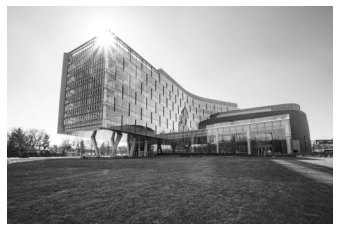

In [3]:
# Load original picture, convert to grayscale
I = np.array(open('Iribe.jpg').convert('L'))/255
plt.imshow(I,cmap='gray')
plt.axis('off')
plt.show()

### Gaussian kernel with standard deviation 3

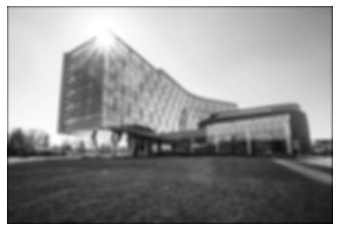

In [4]:
plt.imshow(myfilter(I,gausskernel(3)),cmap='gray')
plt.axis('off')
plt.show()

### Gaussian kernel with standard deviation 5

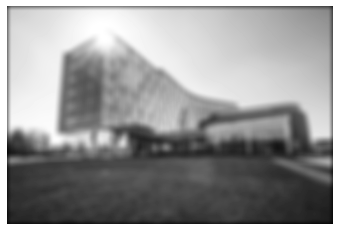

In [5]:
plt.imshow(myfilter(I,gausskernel(5)),cmap='gray')
plt.axis('off')
plt.show()

### Gaussian kernel with standard deviation 10

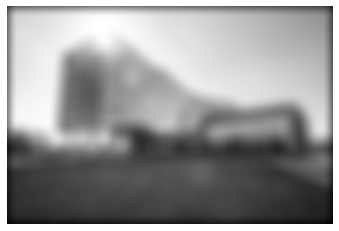

In [6]:
plt.imshow(myfilter(I,gausskernel(10)),cmap='gray')
plt.axis('off')
plt.show()

## 3.3 Filters
### Filter with h1
This filter has two filters summed up. One is a sharpening filter and the other an amplification filter. What this means is that h1 will brighten up the image and sharpen it. 

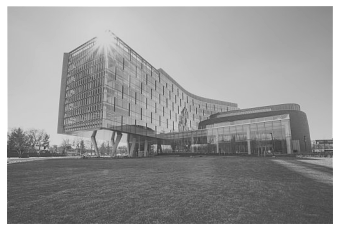

In [7]:
h1=np.array([[-1/9,-1/9,-1/9],[-1/9,2,-1/9],[-1/9,-1/9,-1/9]])
plt.imshow(myfilter(I,h1),cmap='gray')
plt.axis('off')
plt.show()

### Filter with h2
This filter is a one dimensional sharpening filter that sharpens only in the horizontal direction and also makes the image brighter by amplifying the middle.

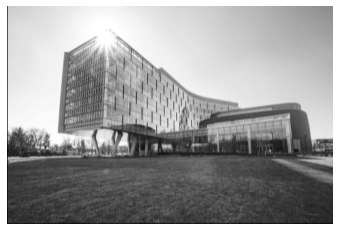

In [8]:
h2=np.array([[-1,3,-1]])
plt.imshow(myfilter(I,h2),cmap='gray')
plt.axis('off')
plt.show()

### Filter with h3
This filter is a one dimensional sharpening filter that sharpens only in the vertical direction and also makes the image brighter by amplifying the middle.

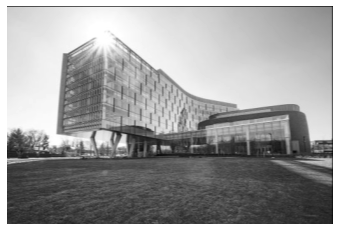

In [9]:
h3=np.array([[-1],[3],[-1]])
plt.imshow(myfilter(I,h3),cmap='gray')
plt.axis('off')
plt.show()

# Part 2: Edge Detection
To completely implement canny edge detection, we have to do the following steps:
 
1. Noise reduction

2. Calculate gradient

3. Thin the edges

4. Hysteresis thresholding

&nbsp;


## 4.1 Noise reduction with gaussian filtering:
Here we simply convolve the gaussian kernel we created in part 1 with the convolution function named myfilter()



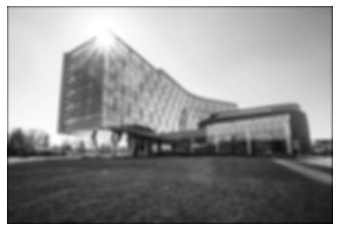

In [10]:
myedges = myfilter(I,gausskernel(3)) #Smooth with gaussian kernel
plt.imshow(myedges,cmap='gray')
plt.axis('off')
plt.show()

## 4.2 Finding Image Gradients
Here I use the given Sx and Sy filters to calculate the derivatives and we use the np.hypot to get the magnitude, I scale it and use the np.arctan function to get the radians. Next, we change those values from radians to angles and we round the angle to the neardest direction.

In [11]:
def gradient(I):
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
    Dx = myfilter(I, Sx)
    Dy = myfilter(I, Sy)
    
    magnitude = np.hypot(Dx, Dy)
    magnitude = magnitude / magnitude.max() * 255
    gAngle = np.arctan2(Dy, Dx)
    gAngle = (gAngle * 180.0)/np.pi   #make sure we convert to degrees

    x, y = np.where(gAngle < 0)
    gAngle[x,y] += 180                 # Flip the negatives so we dont have to add extra checks for those
    
    # Rounding up the angles
    gAngle[(0 <= gAngle) & (gAngle < 22.5)] = 0
    gAngle[(157.5 <= gAngle) & (gAngle <= 180)] = 0
    gAngle[(22.5 <= gAngle) & (gAngle < 67.5)] = 45
    gAngle[(67.5 <= gAngle) & (gAngle < 112.5)] = 90
    gAngle[(112.5 <= gAngle) & (gAngle < 157.5)] = 135

    return (magnitude, gAngle)

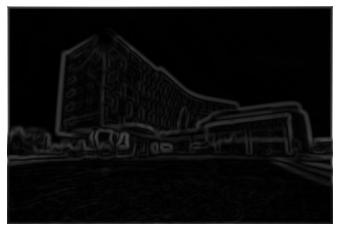

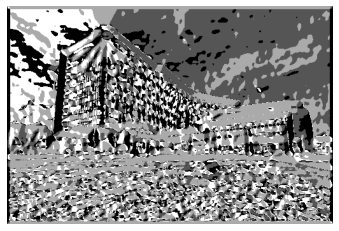

In [12]:
M, A = gradient(myedges) #Find img gradients
plt.imshow(M,cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(A,cmap='gray')
plt.axis('off')
plt.show()

## 4.3 Edge thinning
In this part we will examine 3 pixels at a time depending on the angle. If pixel (i,j) has the highest gradient magnitude of the three pixels examined, it is set to white. If one of the other two pixels has a higher gradient magnitude, then pixel (i,j) is set to black.

In [13]:
def thin_edges(magnitude,gAngle):
    
    thinned_image = np.zeros(magnitude.shape)

    for i in range(1,magnitude.shape[0]-1):
        for j in range(1,magnitude.shape[1]-1):

            # in case it doesnt go into any if statement
            side1 = 255
            side2 = 255
            
            # find what are out side pixels based on the gAngle
            if(gAngle[i,j] == 0):
                side1 = magnitude[i,j+1]
                side2 = magnitude[i,j-1]
            elif (gAngle[i,j] == 135):
                side1 = magnitude[i-1,j-1]
                side2 = magnitude[i+1,j+1]
            elif (gAngle[i,j] == 45):
                side1 = magnitude[i-1,j+1]
                side2 = magnitude[i+1,j-1]
            elif (gAngle[i,j] == 90):
                side1 = magnitude[i-1,j]
                side2 = magnitude[i+1,j]
            
            #if any of the side pixels are larger, make the output 0
            if(side1 > magnitude[i,j] or side2 > magnitude[i,j]):
                thinned_image[i,j] = 0
            else:
                thinned_image[i,j] = magnitude[i,j]
            
           
    return(thinned_image)

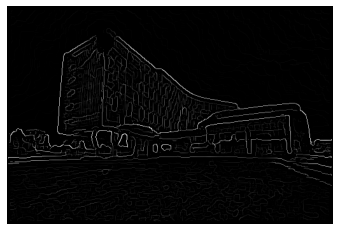

In [14]:
myedges = thin_edges(M,A) #Thin edges
plt.imshow(myedges,cmap='gray')
plt.axis('off')
plt.show()

## 4.4 Hysterisis Thresholding
Here I use the high threshold to identify strong pixels and the low threshold to identify irrelevant pixels. The pixels that are in between these thresholds will be compares to the neighboring pixels using the function label() and it will check if there is a pixel with a high value in that group. If this is true, then it will make the whole group into strong pixels. 

In [15]:
def hysterisis(I, low, high):
    high = I.max() * high
    low = high * low
    I[(I < low)] = 0
    I[(I >= low) & (I < high)] = 50
    I[(I > high)] = 255

    labeled_array, num_features = label(I)
    for i in range(1, I.shape[0]-1):
        for j in range(1, I.shape[1]-1):
            if (I[i,j] != 0 and I[i,j] != 255):
                x, y = np.where(labeled_array == labeled_array[i,j]) #places with same label
                if(np.any(I[x,y] == 255)):
                    I[x,y] = 255
                else:
                    I[x,y] = 0


    return I


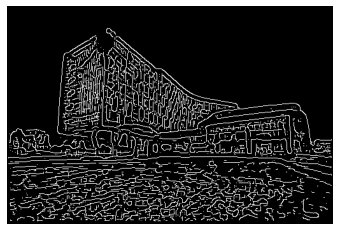

In [16]:
myedges = hysterisis(myedges, 0.15, 0.3) #Hysteresis thresholding
plt.imshow(myedges,cmap='gray')
plt.axis('off')
plt.show()

## 4.5 Testing
Here I will use different values of sigma, tlow and thigh and show the different results

NOTE: I have added interpolation='none' to the graphs to have a more accurate representation of the values

In [17]:
def myCanny(I,sigma,t_low,t_high):
    myedges = myfilter(I,gausskernel(sigma)) #Smooth with gaussian kernel
    M, A = gradient(myedges) #Find img gradients
    myedges = thin_edges(M,A) #Thin edges
    myedges = hysterisis(myedges, t_low, t_high) #Hystersis thresholding
    return myedges

## Model Image

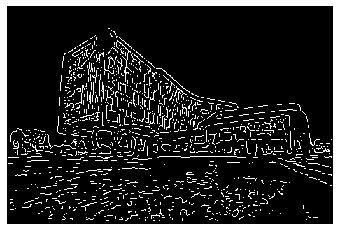

In [18]:
edges=myCanny(I,sigma=3,t_low=0.25,t_high=0.3)
plt.imshow(edges, interpolation='none',cmap='gray')
plt.axis('off')
plt.show()

## Increased Sigma
Since we are blurring the image more, edges are smother and certain details are lost

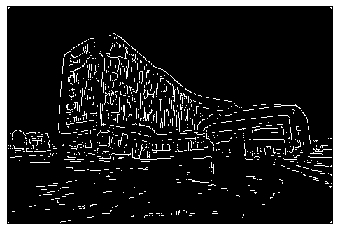

In [19]:
edges=myCanny(I,sigma=5,t_low=0.25,t_high=0.3)
plt.imshow(edges, interpolation='none',cmap='gray')
plt.axis('off')
plt.show()

## Lower t_low
Lowering the threshold would allow more pixels to be white, causing unwanted lines to appear.

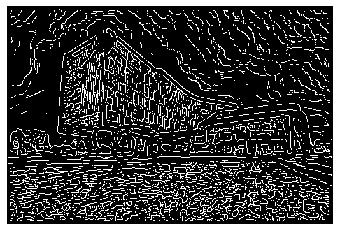

In [20]:
edges=myCanny(I,sigma=3,t_low=0.05,t_high=0.3)
plt.imshow(edges, interpolation='none',cmap='gray')
plt.axis('off')
plt.show()

## Increase t_high
Increaseing the threshold would place more pixels in the inbetween threshold area. This means that there will be more pixels connected to a white pixels that will turn white.

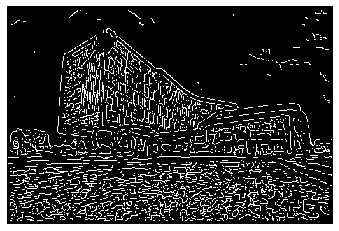

In [21]:
edges=myCanny(I,sigma=3,t_low=0.05,t_high=0.5)
plt.imshow(edges, interpolation='none',cmap='gray')
plt.axis('off')
plt.show()

# Extra credit
Here I combine the low frequencies of one image with the high frequencies of another to form ahybrid image. The images used are found online for hybrid image purposes. 

## 1 Load Images

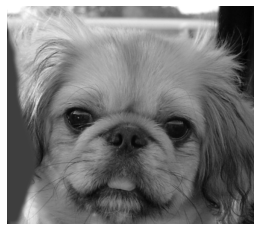

In [22]:
demo1 = np.array(open('dog.jpg').convert('L'))/255
plt.imshow(demo1,cmap='gray')
plt.axis('off')
plt.show()

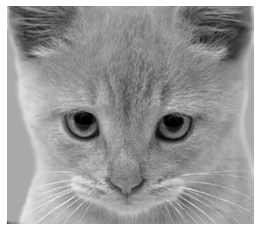

In [23]:
demo2 = np.array(open('cat.jpg').convert('L'))/255
plt.imshow(demo2,cmap='gray')
plt.axis('off')
plt.show()

## 2 Get High Frequency
Here I get the high frequency image from the cat by getting the low frequency image gather by the gaussian filter and subtracting it from the original image. 

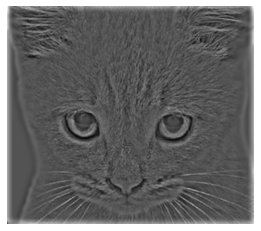

In [24]:
high = demo2 - myfilter(demo2,gausskernel(7))
low = myfilter(demo1,gausskernel(7))
plt.imshow(high,cmap='gray')
plt.axis('off')
plt.show()

## 3 Get Low Frecuency
Get the low frecuency image from the dog by applying the gaussian filter. 

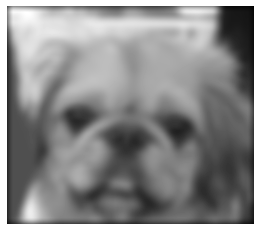

In [25]:
plt.imshow(low,cmap='gray')
plt.axis('off')
plt.show()

## 4 Hybrid Image
Here I combine the images by adding them and dividing by 2.

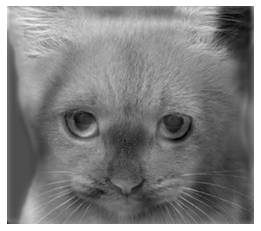

In [26]:
combined = (low + high)/2
plt.imshow(combined,cmap='gray')
plt.axis('off')
plt.show()
plt.imsave('result.png',combined,cmap='gray')

## 5.1 Results: Image from far away
When looked from far away, we can see the image of the dog as seen bellow.

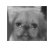

In [27]:
result1 = np.array(open('result.PNG').convert('L'))/255
plt.figure(figsize = (0.7,0.7))
plt.imshow(result1,cmap='gray')
plt.axis('off')
plt.show()

## 5.2 Results: Image up close
When looked from up close, we can see the image of the cat. 

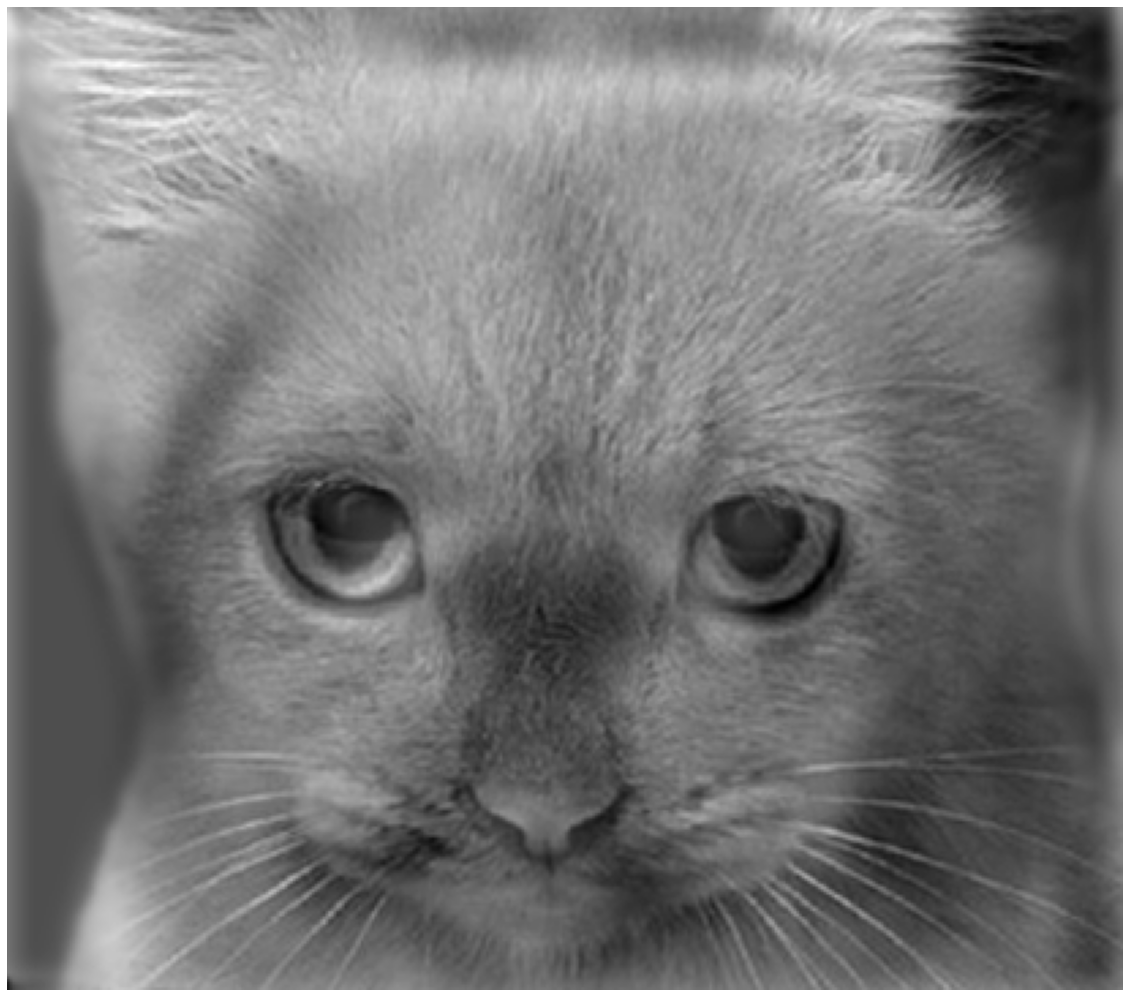

In [28]:
result2 = np.array(open('result.PNG'))
plt.figure(figsize = (20,20))
plt.imshow(result2,cmap='gray')
plt.axis('off')
plt.show()